In [1]:
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf

2025-04-24 17:06:18.011792: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-24 17:06:19.355870: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745535979.612397   50657 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745535979.757984   50657 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-24 17:06:20.800169: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
def get_biome_param_names(b):
    u_params = ['jmaxb1', 'wc2wjb0', 'grperc', 'theta_cj', 'tpu25ratio', 'lmrse',
       'vcmaxha', 'jmaxha', 'tpuha', 'lmrha', 'ACCLIM_SF', 'fstor2tran',
       'crit_onset_gdd_sf', 'FUN_fracfixers', 'fff', 'e_ice', 'bsw_sf',
       'sucsat_sf', 'watsat_sf', 'hksat_sf', 'om_frac_sf', 'baseflow_scalar',
       'maximum_leaf_wetted_fraction', 'interception_fraction', 'cv', 'd_max',
       'z0v_Cr', 'n_melt_coef', 'accum_factor', 'xdrdt',
       'upplim_destruct_metamorph', 'snw_rds_refrz', 'decomp_depth_efolding',
       'TAU', 'q10_mr', 'minpsi_hr', 'maxpsi_hr', 'RF_LS', 'RF_SS', 'RF_CWD',
       'pot_hmn_ign_counts_alpha']

    pft_params   = ['kmax','psi50','jmaxb0','slatop','lmr_intercept_atkin',
                'medlynslope','medlynintercept','froot_leaf','leafcn','leaf_long',
               'KCN','dleaf','r_mort','fsr_pft','xl']
    
    with open(utils_dir+"/biome_configs.pkl", "rb") as f:
        biome_configs = pickle.load(f)

    param_names = list(u_params)
    for pft in biome_configs[b]['pfts']:
        pft_param_names = [f"{param}_{pft}" for param in pft_params]
        param_names.extend(pft_param_names)

    return param_names

### setup

In [3]:
import sys
sys.path.append('/glade/u/home/linnia/ctsm6_ppe/')
from utils.pyfunctions import *
utils_path = '/glade/u/home/linnia/ctsm6_ppe/utils/'

In [4]:
# get parameter info
key = '/glade/work/linnia/CLM6-PPE/ctsm6_lhc/ctsm6lhc_11262024.txt'
params_lhc = pd.read_csv(key).drop(columns='member')

pft_params   = ['kmax','psi50','jmaxb0','slatop','lmr_intercept_atkin',
                'medlynslope','medlynintercept','froot_leaf','leafcn','leaf_long',
               'KCN','dleaf','r_mort','fsr_pft','xl']
pftix=np.array([p in pft_params for p in params_lhc.columns])
u_params = params_lhc.columns[~pftix]

In [5]:
# get biome information
with open(utils_dir+"/biome_configs.pkl", "rb") as f:
    biome_configs = pickle.load(f)

# get observations
obs_biome = xr.open_dataset(utils_path + 'wave2_obsStatistics_sudokuBiomes.nc')

# get default parameter set
default_params = pd.read_csv('default_params_norm.csv', index_col=False)

In [6]:
# reset some settings of default parameters
default_params.loc[0, ['jmaxb1']] = [0.4]
default_params.loc[0, ['theta_cj']] = [0.7]
default_params.loc[0, ['upplim_destruct_metamorph']] = [1]

### Single variable optimization

In [124]:
def loss_fn(x, universal_set, biome_info, epsilon=None, mu=0.0):
    """
    Compute total loss (including log-barrier) and max error for a batch of initializations x.
    x: tf.Tensor, shape [batch, x_dim]
    universal_set: tf.Tensor, shape [u_dim]
    biome_info: list of dicts with 'param_indices', 'target', 'emulator'
    epsilon: scalar tolerance
    mu: barrier strength
    Returns:
      total_loss: scalar (sum of losses across batch plus barrier)
      max_err: scalar (worst error across all biomes and inits)
    """
    batch = tf.shape(x)[0]
    u = tf.expand_dims(universal_set, 0)
    u_tiled = tf.tile(u, [batch, 1])

    loss_per_init = tf.zeros((batch,), dtype=tf.float64)
    max_err = tf.constant(0.0, dtype=tf.float64)

    for biome in biome_info:
        full_sample = tf.concat([u_tiled, x], axis=1)
        ix = biome['param_indices']
        biome_sample = tf.gather(full_sample, ix, axis=1)

        y_pred, _ = biome['emulator'].predict(biome_sample)
        target = tf.reshape(biome['target'], (1, -1))
        target_tiled = tf.tile(target, [batch, 1])
        stdev = tf.reshape(biome['stdev'], (1, -1))
        stdev_tiled = tf.tile(stdev, [batch, 1])
        error = tf.abs((y_pred - target_tiled) / stdev_tiled)

        if epsilon is not None:
            mask = tf.cast(tf.abs(error) > epsilon, tf.float64) # mask out those within epsilon
            loss_b = tf.reduce_sum(mask * tf.square(error), axis=1)
        else:
            loss_b = tf.reduce_sum(tf.square(error), axis=1)

        loss_per_init += loss_b
        max_err = tf.maximum(max_err, tf.reduce_max(tf.abs(error)))

    # mean of per-init losses
    data_loss = tf.reduce_mean(loss_per_init)

    # log-barrier to keep x strictly within (0,1)
    # clip x to avoid log(0) or log(negative)
    #eps = tf.constant(1e-6, dtype=tf.float64)
    #x_safe = tf.clip_by_value(x, eps, 1.0 - eps)
    #barrier = -mu * tf.reduce_sum(tf.math.log(x_safe) + tf.math.log(1.0 - x_safe))

    total_loss = data_loss #+ barrier
    return total_loss, max_err



In [125]:

def run_tf_optimization(universal_set, biome_info,
                        x0=None, learning_rate=0.01,
                        maxiter=1000, epsilon=None, mu=1e-3):
    # x0: numpy array of shape [n_inits, x_dim]
    x = tf.Variable(x0, dtype=tf.float64)
    optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

    for step in range(maxiter):
        with tf.GradientTape() as tape:
            loss, max_err = loss_fn(x, universal_set, biome_info,
                                    epsilon=epsilon, mu=mu)
        grads = tape.gradient(loss, [x])[0]

        if epsilon is not None and max_err.numpy() <= epsilon:
            print(f"Converged at step {step}, max_err={max_err.numpy():.4f}")
            break

        optimizer.apply_gradients([(grads, x)])
        # hard-projection to enforce [0,1] bounds
        x.assign(tf.clip_by_value(x, 0.0, 1.0))

        if step % 10 == 0 or step == maxiter - 1:
            print(f"Step {step}: loss = {loss.numpy():.4f}, max_err = {max_err.numpy():.4f}")

    return x.numpy()


In [140]:
# setup
emulator_path = '/glade/u/home/linnia/ctsm6_ppe/calibration/emulators_biomelai/'

biomes = [1,2,3]
biome_info = []
for b in biomes:
    biome_name = biome_configs[b]['name']
    param_names = get_biome_param_names(b)
    param_indices = [default_params.columns.get_loc(p)for p in param_names]

    biome_info.append({
        'biome': b,
        'param_indices': tf.constant(param_indices, dtype=tf.int32),
        'target': tf.convert_to_tensor(obs_biome.LAI_mean.isel(biome=b).values, dtype=tf.float64),
        'stdev': tf.convert_to_tensor(obs_biome.LAI_stdev.isel(biome=b).values, dtype=tf.float64),
        'emulator': tf.saved_model.load(emulator_path + biome_name),
    })


# Build universal_set tensor
universal_set = default_params[u_params].iloc[[0]].values
universal_set = tf.convert_to_tensor(universal_set, dtype=tf.float64)
universal_set = tf.reshape(universal_set, [-1])


In [141]:
%%time
n_inits = 100
dim = 195
x0 = np.tile(np.linspace(0.1, 0.9, n_inits).reshape(n_inits, 1), (1, dim))

# Run optimization
tol = 1E-3
maxiter = 100
learning_rate=0.01
epsilon = 1 # one standard deviation
mu = 1e-3
result_array = run_tf_optimization(universal_set, biome_info,
                                   x0=x0,
                                   learning_rate=learning_rate,
                                   maxiter=maxiter,
                                   epsilon=epsilon,
                                   mu=mu)


Step 0: loss = 5397.5105, max_err = 6.6549
Step 10: loss = 1156.4380, max_err = 3.5202
Step 20: loss = 400.6400, max_err = 2.9265
Step 30: loss = 215.6963, max_err = 2.6297
Step 40: loss = 97.2275, max_err = 2.1930
Step 50: loss = 39.4772, max_err = 1.6121
Converged at step 60, max_err=0.9817
CPU times: user 7min 18s, sys: 22.2 s, total: 7min 40s
Wall time: 14min 35s


In [142]:
uset_tiled = np.tile(default_params[u_params].values[0], (n_inits,1))
opt_sets = np.concatenate([uset_tiled,result_array],axis=1)
full_calibrated_paramsets = pd.DataFrame(opt_sets,columns=default_params.columns.values)

In [145]:
emulator_path = '/glade/u/home/linnia/ctsm6_ppe/calibration/emulators_biomelai/'
for b in range(1,4):
    biome_name = biome_configs[b]['name']
    biome_param_names = get_biome_param_names(b)
    samp = full_calibrated_paramsets[biome_param_names]
    loaded_emulator = tf.saved_model.load(emulator_path + biome_name)
    y_pred, _ = loaded_emulator.predict(samp.values)
    #error = y_pred.numpy().ravel() - obs_biome.LAI_mean.isel(biome=b).values
    error = tf.abs((y_pred.numpy().ravel() - obs_biome.LAI_mean.isel(biome=b).values) / obs_biome.LAI_stdev.isel(biome=b).values)
    print(biome_name + str(error))

Subtropical savannatf.Tensor(
[0.63376674 0.60995381 0.48184039 0.37045745 0.39567699 0.50866562
 0.8057125  0.6882301  0.66970097 0.69957648 0.61742359 0.61631014
 0.46207203 0.41334215 0.42022935 0.40215857 0.38551215 0.36272199
 0.3209378  0.32948519 0.27057757 0.23538798 0.22171362 0.17827446
 0.22836352 0.13550374 0.14168597 0.12421655 0.06663125 0.08265711
 0.01403637 0.02867059 0.01246385 0.0021819  0.04119136 0.01233895
 0.02082881 0.03664411 0.02686423 0.0760295  0.066479   0.09891153
 0.08612328 0.15172952 0.11385627 0.11739859 0.15089654 0.13556775
 0.18332761 0.15287506 0.14306392 0.17610866 0.1526549  0.21611527
 0.19041636 0.25273016 0.24110555 0.22325136 0.2696465  0.25901508
 0.29578583 0.30428532 0.3690992  0.38980259 0.46692704 0.473116
 0.48969221 0.5114741  0.53924246 0.54470142 0.56984085 0.57977653
 0.57913353 0.57851375 0.58604047 0.59870488 0.61699251 0.62478312
 0.63525154 0.64663078 0.65406094 0.66849985 0.68463743 0.70245778
 0.74237246 0.76165548 0.79219517 

### plot to check

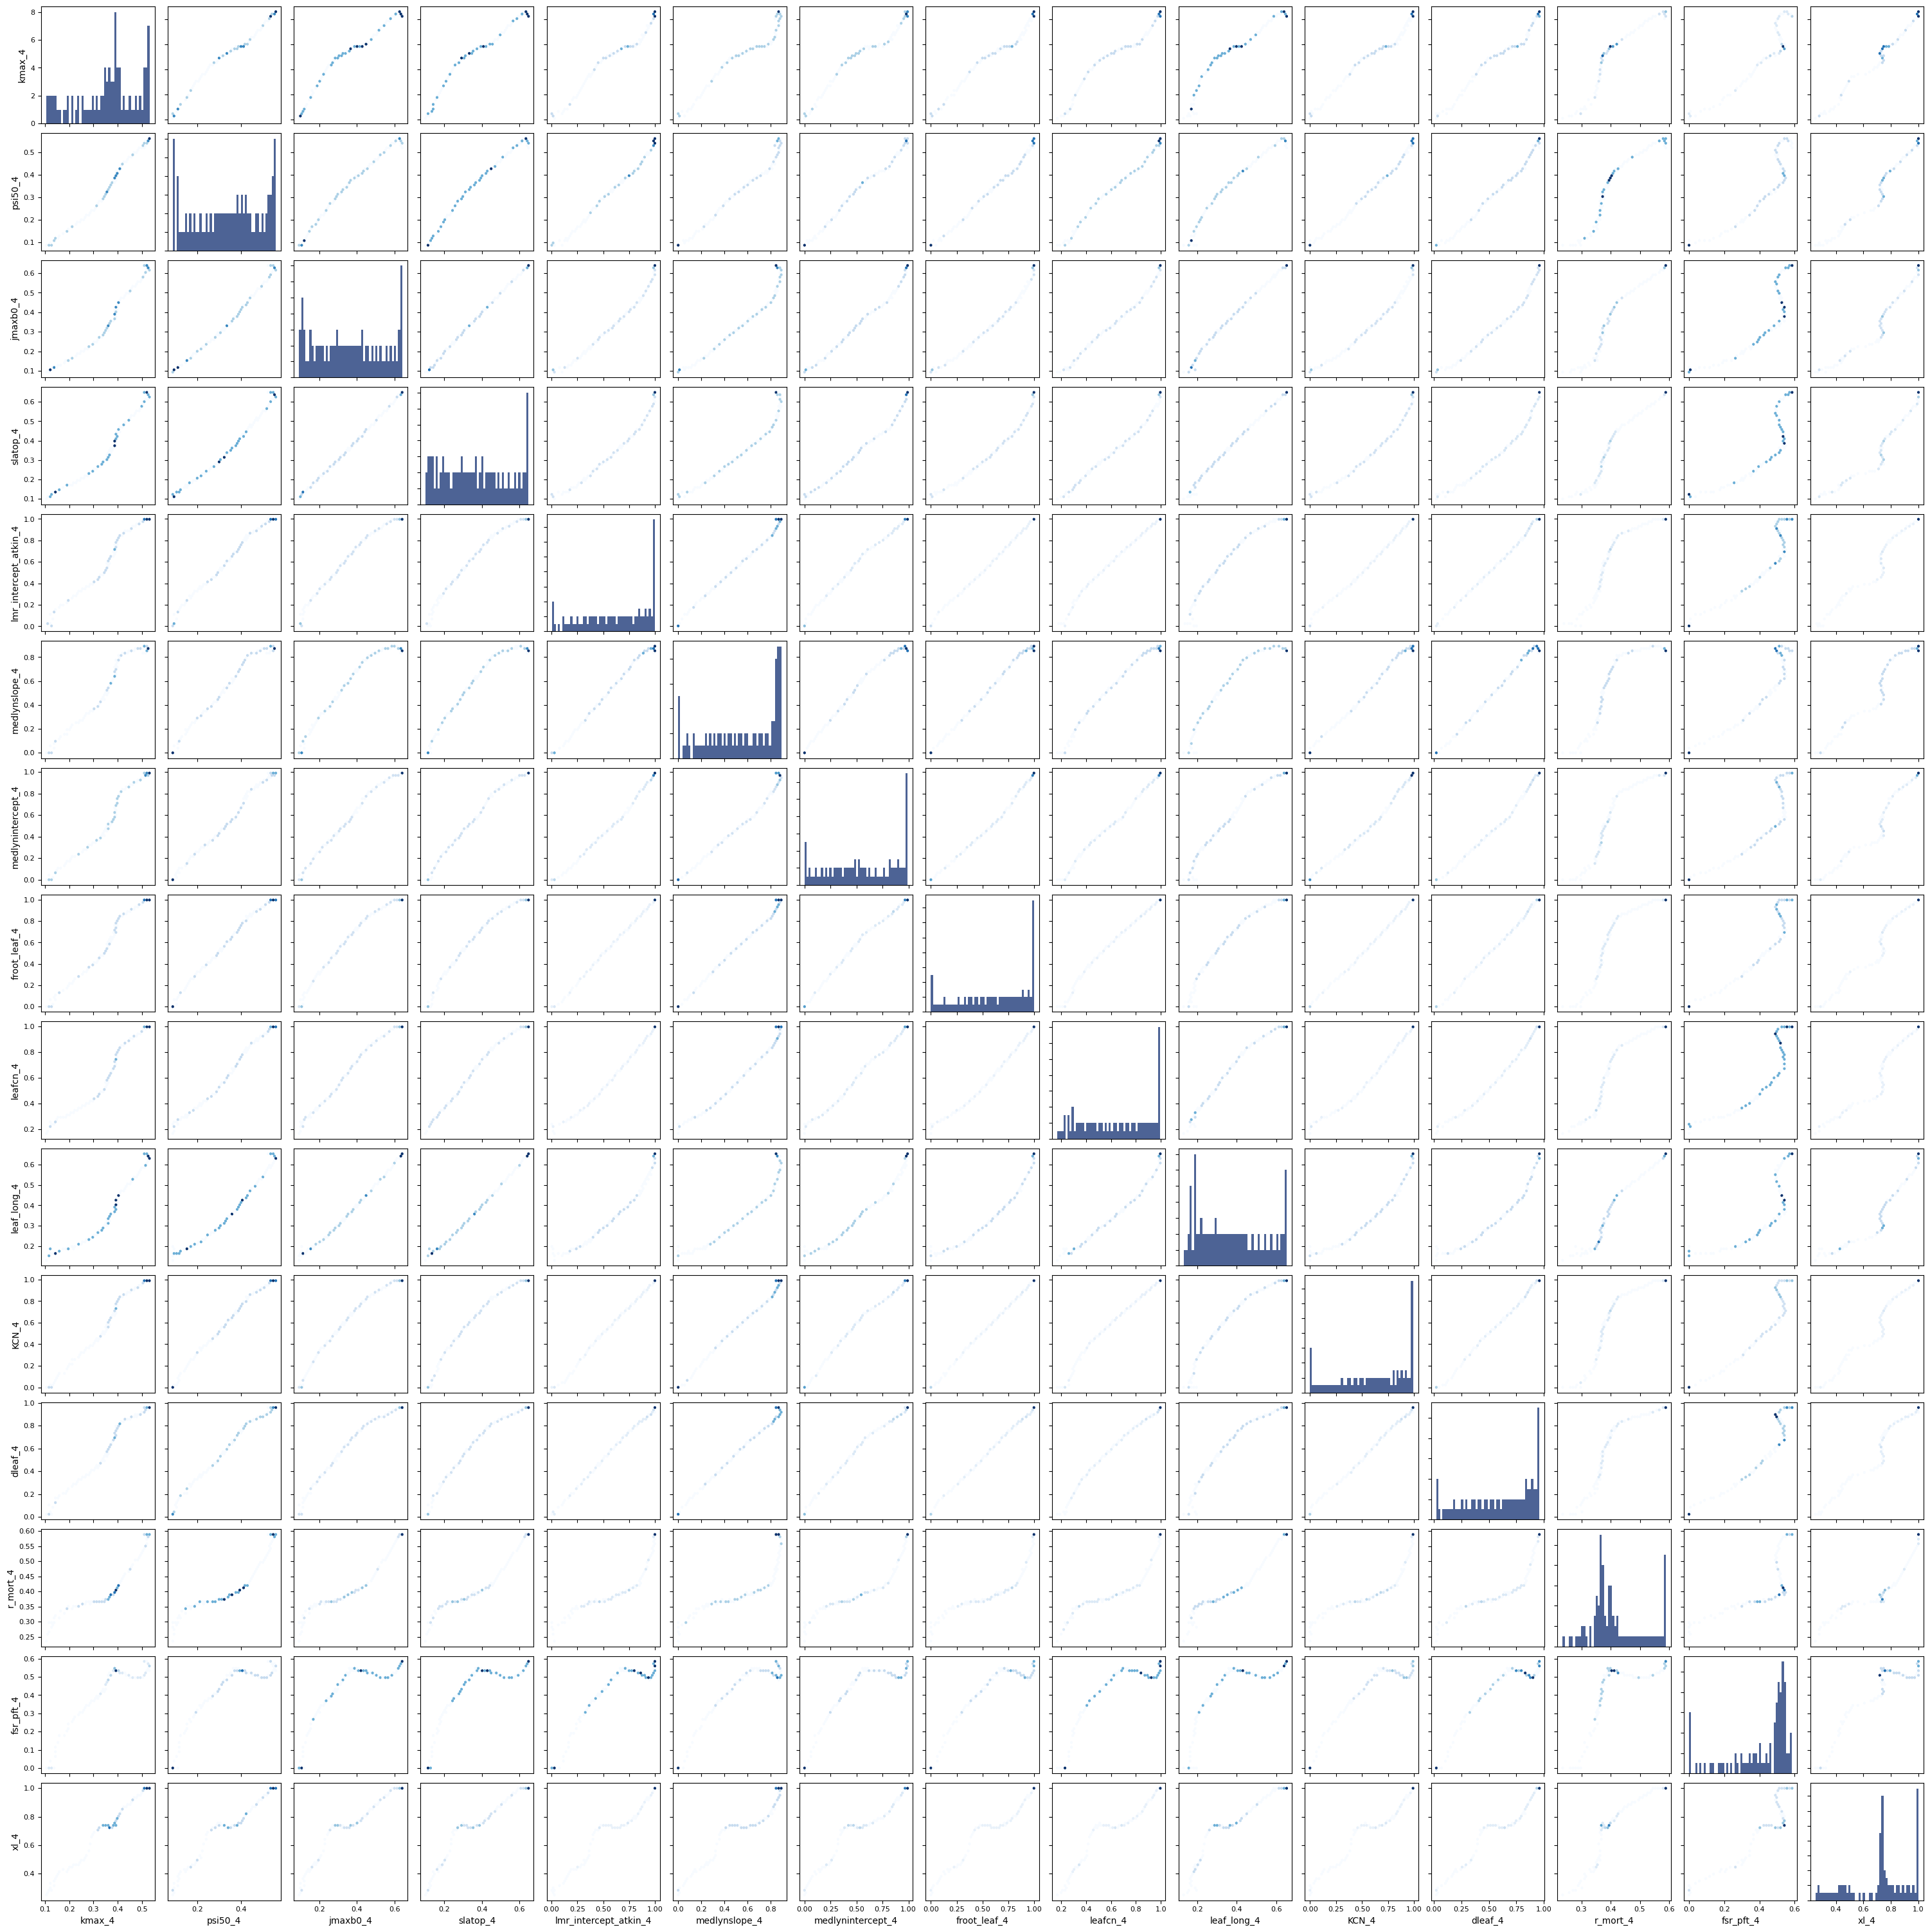

In [146]:

# Define LEAP colors
leap_colors = ['#B9D9EB', '#00796B', '#012169']

# Prepare data
pft = 4
pft_param_names = [f"{param}_{pft}" for param in pft_params]
data = full_calibrated_paramsets[pft_param_names]

n = len(pft_param_names)

# Set plot-wide styles
plt.rcParams.update({
    'font.size': 10,         # Font size
    'axes.labelsize': 12,    # Axis label size
    'xtick.labelsize': 8, 
    'ytick.labelsize': 8,
    'axes.linewidth': 0.8,   # Thin frame lines
    'savefig.dpi': 300,
})

fig, axes = plt.subplots(n, n, figsize=(2*n, 2*n))  # Larger, scalable size

for i in range(n):
    for j in range(n):
        ax = axes[i, j]
        if i == j:
            # 1D histogram on the diagonal
            ax.hist(data[pft_param_names[i]], bins=50, color=leap_colors[2], alpha=0.7)
        else:
            # 2D hexbin on the off-diagonals
            hb = ax.hexbin(
                data[pft_param_names[j]],
                data[pft_param_names[i]],
                gridsize=40,
                cmap='Blues',       
                mincnt=1,           # Only show bins with data
                linewidths=0
            )
            # Fix hexbin color to LEAP navy color
            #hb.set_cmap('Blues')
            #hb.set_array(hb.get_array()*0+1)  # Uniform color intensity
            #hb.set_edgecolor('none')
            #hb.set_facecolor(leap_colors[2])  # Dark navy

        # Clean ticks
        if i < n-1:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel(pft_param_names[j], fontsize=10)
        if j > 0:
            ax.set_yticklabels([])
        else:
            ax.set_ylabel(pft_param_names[i], fontsize=10)

plt.tight_layout(pad=0.5)
#plt.savefig('./figs/hexbin_scattermatrix_pftparams_pft'+str(pft)+'.png', dpi = 300)

### Multiple variable optimization

In [7]:
# get observations & set stdev so high the optimization ignores some biome/variable combinations
obs = xr.open_dataset(utils_path + 'wave2_obsStatistics_sudokuBiomes.nc')
obs_biome = obs.copy()
obs_biome['biomassC_stdev'].loc[{'biome': 12}] = 100

In [8]:
def loss_fn_multivar(x, universal_set, biome_info, epsilon=None, mu=0.0):

    batch = tf.shape(x)[0]
    u = tf.expand_dims(universal_set, 0)
    u_tiled = tf.tile(u, [batch, 1])

    loss_per_init = tf.zeros((batch,), dtype=tf.float64)
    max_err = tf.constant(0.0, dtype=tf.float64)

    for biome in biome_info:
        full_sample = tf.concat([u_tiled, x], axis=1)
        ix = biome['param_indices']
        biome_sample = tf.gather(full_sample, ix, axis=1)

        for emulator, target, stdev in zip(biome['emulators'], biome['targets'], biome['stdevs']):
            y_pred, _ = emulator.predict(biome_sample)
            target = tf.reshape(target, (1, -1))
            target_tiled = tf.tile(target, [batch, 1])
            stdev = tf.reshape(stdev, (1, -1))
            stdev_tiled = tf.tile(stdev, [batch, 1])
            error = tf.abs((y_pred - target_tiled) / stdev_tiled)
    
            if epsilon is not None:
                mask = tf.cast(tf.abs(error) > epsilon, tf.float64) # mask out those within epsilon
                loss_b = tf.reduce_sum(mask * tf.square(error), axis=1)
            else:
                loss_b = tf.reduce_sum(tf.square(error), axis=1)
    
            loss_per_init += loss_b
            max_err = tf.maximum(max_err, tf.reduce_max(tf.abs(error)))

    # mean of per-init losses
    data_loss = tf.reduce_mean(loss_per_init)

    # log-barrier to keep x strictly within (0,1)
    # clip x to avoid log(0) or log(negative)
    #eps = tf.constant(1e-6, dtype=tf.float64)
    #x_safe = tf.clip_by_value(x, eps, 1.0 - eps)
    #barrier = -mu * tf.reduce_sum(tf.math.log(x_safe) + tf.math.log(1.0 - x_safe))

    total_loss = data_loss #+ barrier
    return total_loss, max_err


In [15]:
def run_tf_optimization(universal_set, biome_info,
                        x0=None, learning_rate=0.01,
                        maxiter=1000, epsilon=None, mu=1e-3):
    # x0: numpy array of shape [n_inits, x_dim]
    x = tf.Variable(x0, dtype=tf.float64)

    # Learning rate schedule: decay by half every 100 steps
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=learning_rate,
        decay_steps=10,
        decay_rate=0.5,
        staircase=True)
    
    optimizer = tf.optimizers.Adam(learning_rate=lr_schedule)

    for step in range(maxiter):
        with tf.GradientTape() as tape:
            loss, max_err = loss_fn_multivar(x, universal_set, biome_info,
                                    epsilon=epsilon, mu=mu)
        grads = tape.gradient(loss, [x])[0]

        if epsilon is not None and max_err.numpy() <= epsilon:
            print(f"Converged at step {step}, max_err={max_err.numpy():.4f}")
            break

        optimizer.apply_gradients([(grads, x)])
        # hard-projection to enforce [0,1] bounds
        x.assign(tf.clip_by_value(x, 0.0, 1.0))

        if step % 10 == 0 or step == maxiter - 1:
            print(f"Step {step}: loss = {loss.numpy():.4f}, max_err = {max_err.numpy():.4f}")

    return x.numpy()

In [16]:
# setup
paths = {
    'lai': '/glade/u/home/linnia/ctsm6_ppe/calibration/emulators_biomelai/',
    'gpp': '/glade/u/home/linnia/ctsm6_ppe/calibration/emulators_biomegpp/',
    'biomass': '/glade/u/home/linnia/ctsm6_ppe/calibration/emulators_biomebiomass/'
}

biomes = [1,2,3,5,6,7,8,9,10,11,12,13]
biome_info = []
for b in biomes:
    biome_name = biome_configs[b]['name']
    param_names = get_biome_param_names(b)
    param_indices = [default_params.columns.get_loc(p)for p in param_names]

    emulators = [
        tf.saved_model.load(f"{paths['lai']}{biome_name}"),
        tf.saved_model.load(f"{paths['gpp']}{biome_name}"),
        tf.saved_model.load(f"{paths['biomass']}{biome_name}")
    ]
    targets = [
        tf.convert_to_tensor(obs_biome.LAI_mean.isel(biome=b).values, dtype=tf.float64),
        tf.convert_to_tensor(obs_biome.GPP_mean.isel(biome=b).values, dtype=tf.float64),
        tf.convert_to_tensor(obs_biome.biomassC_mean.isel(biome=b).values, dtype=tf.float64)
    ]
    target_stdevs = [
        tf.convert_to_tensor(obs_biome.LAI_stdev.isel(biome=b).values, dtype=tf.float64),
        tf.convert_to_tensor(obs_biome.GPP_stdev.isel(biome=b).values, dtype=tf.float64),
        tf.convert_to_tensor(obs_biome.biomassC_stdev.isel(biome=b).values, dtype=tf.float64)
    ]

    biome_info.append({
        'biome': b,
        'param_indices': tf.constant(param_indices, dtype=tf.int32),
        'emulators': emulators,
        'targets': targets,
        'stdevs': target_stdevs,
    })

# Build universal_set tensor
universal_set = default_params[u_params].iloc[[0]].values
universal_set = tf.convert_to_tensor(universal_set, dtype=tf.float64)
universal_set = tf.reshape(universal_set, [-1])


In [17]:
# initialization version 1: one-at-a-time
pft_cols = [c for c in default_params.columns if c not in u_params]
default_pftparams = default_params[pft_cols].iloc[0].values  

# Build one-at-a-time sweep from 0.1 to 0.9 in steps of 0.1
increments = np.arange(0.1, 1.0, 0.1)              
x0_list = []
for dim_idx in range(len(pft_cols)):
    for v in increments:
        row = default_pftparams.copy()
        row[dim_idx] = v
        x0_list.append(row)

x0 = np.stack(x0_list, axis=0)

In [14]:
# initialization version 2: sample from normal priors around default
pft_cols     = [c for c in default_params.columns if c not in u_params]
default_pftparams = default_params[pft_cols].iloc[0].values   

n_inits = 100
sigma   = 0.01   # spread of your normal draws

np.random.seed(42)   # for reproducibility, optional
x0 = np.random.normal(loc=default_pftparams,
                      scale=sigma,
                      size=(n_inits, default_pftparams.size))

# enforce bounds [0,1]
x0 = np.clip(x0, 0.0, 1.0)


In [ ]:
# initialization version 3: pairwise 
import itertools

pft_cols     = [c for c in default_params.columns if c not in u_params]
default_pftparams = default_params[pft_cols].iloc[0].values
increments = [0.1, 0.3, 0.7, 0.9]

x0_list = []
for (i, j) in itertools.combinations(range(len(pft_cols)), 2):
    for v1, v2 in itertools.product(increments, repeat=2):
        row = default_pftparams.copy()
        row[i], row[j] = v1, v2
        x0_list.append(row)

x0_grid = np.stack(x0_list, axis=0)
# x0_grid.shape == (n_pairs * len(increments)**2, n_pft_params)


In [ ]:
%%time
#n_inits = 30
#dim = 195
#x0 = np.tile(np.linspace(0.1, 0.9, n_inits).reshape(n_inits, 1), (1, dim))

# Run optimization
tol = 1E-2
maxiter = 100
learning_rate=0.1
epsilon = 1 # standard deviations
mu = 1e-3
result_array = run_tf_optimization(universal_set, biome_info,
                                   x0=x0,
                                   learning_rate=learning_rate,
                                   maxiter=maxiter,
                                   epsilon=epsilon,
                                   mu=mu)


Step 0: loss = 719.0508, max_err = 18.4394


In [ ]:
uset_tiled = np.tile(default_params[u_params].values[0], (n_inits,1))
opt_sets = np.concatenate([uset_tiled,result_array],axis=1)
full_calibrated_paramsets = pd.DataFrame(opt_sets,columns=default_params.columns.values)

In [ ]:
full_calibrated_paramsets.to_csv('opt_tensorflow_allbiomes_allvars_initOAAT.csv')

In [12]:
full_calibrated_paramsets = pd.read_csv('opt_tensorflow_allbiomes_allvars_initNearDefault.csv',index_col=0)

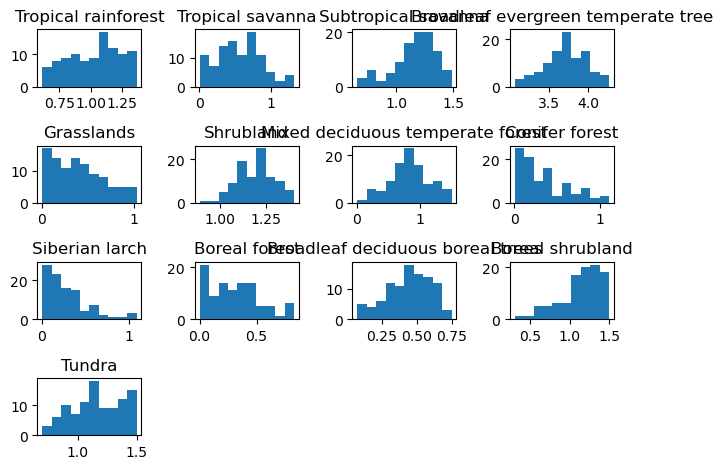

In [18]:
emulator_path = '/glade/u/home/linnia/ctsm6_ppe/calibration/emulators_biomegpp/'
for b in range(1,14):
    plt.subplot(4,4,b)
    biome_name = biome_configs[b]['name']
    biome_param_names = get_biome_param_names(b)
    samp = full_calibrated_paramsets[biome_param_names]
    loaded_emulator = tf.saved_model.load(emulator_path + biome_name)
    y_pred, _ = loaded_emulator.predict(samp.values)
    
    error = tf.abs((y_pred.numpy().ravel() - obs_biome.GPP_mean.isel(biome=b).values) / obs_biome.GPP_stdev.isel(biome=b).values)
    plt.hist(error)
    plt.title(biome_name)
plt.tight_layout()

### Plot posteriors

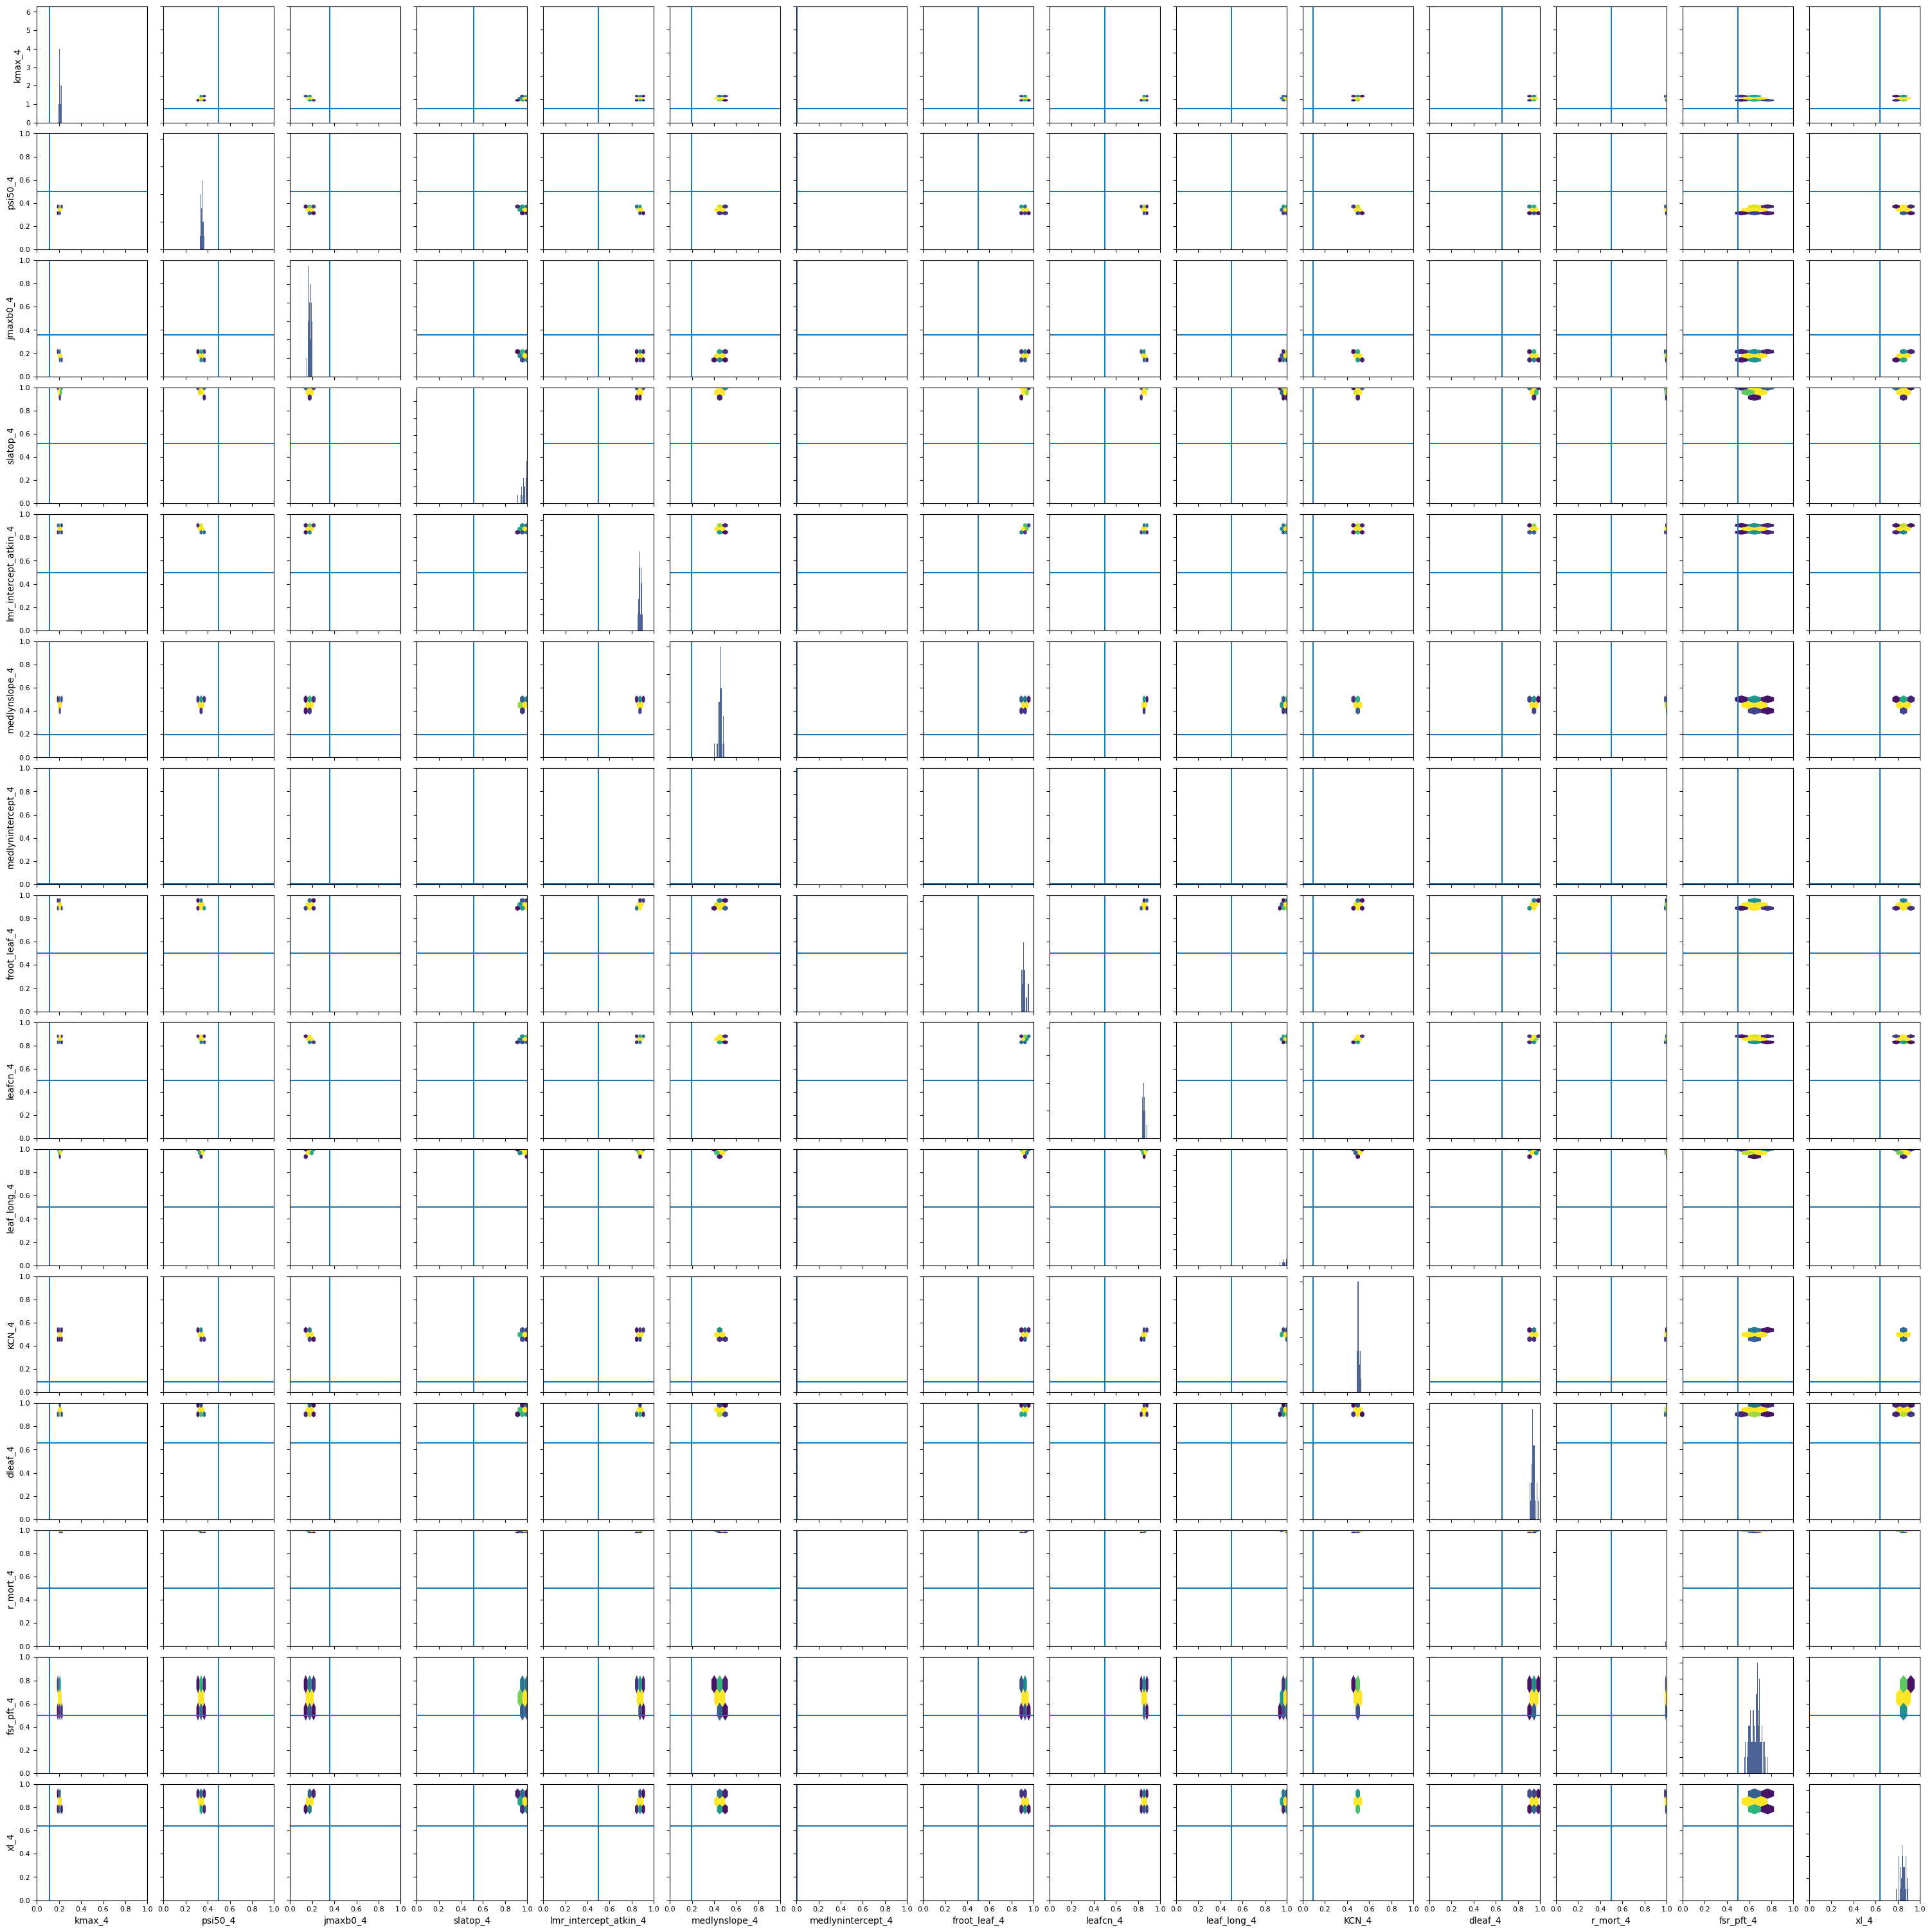

In [40]:
# Define LEAP colors
leap_colors = ['#B9D9EB', '#00796B', '#012169']

# Prepare data
pft = 4
pft_param_names = [f"{param}_{pft}" for param in pft_params]
data = full_calibrated_paramsets[pft_param_names]

n = len(pft_param_names)

# Set plot-wide styles
plt.rcParams.update({
    'font.size': 10,         # Font size
    'axes.labelsize': 12,    # Axis label size
    'xtick.labelsize': 8, 
    'ytick.labelsize': 8,
    'axes.linewidth': 0.8,   # Thin frame lines
    'savefig.dpi': 300,
})

fig, axes = plt.subplots(n, n, figsize=(2*n, 2*n))  # Larger, scalable size

for i in range(n):
    for j in range(n):
        ax = axes[i, j]
        if i == j:
            # 1D histogram on the diagonal
            ax.hist(data[pft_param_names[i]], bins=50, color=leap_colors[2], alpha=0.7)
            ax.axvline(default_params[pft_param_names[i]].values)
            ax.set_xlim([0,1])
        else:
            # 2D hexbin on the off-diagonals
            hb = ax.hexbin(
                data[pft_param_names[j]],
                data[pft_param_names[i]],
                gridsize=2,
                #cmap='Blues',
                vmin=0,
                vmax=20,
                mincnt=1,           # Only show bins with data
                linewidths=0
            )
            # Fix hexbin color to LEAP navy color
            #hb.set_cmap('Blues')
            #hb.set_array(hb.get_array()*0+1)  # Uniform color intensity
            #hb.set_edgecolor('none')
            #hb.set_facecolor(leap_colors[2])  # Dark navy
            ax.axvline(default_params[pft_param_names[j]].values)
            ax.axhline(default_params[pft_param_names[i]].values)
            ax.set_ylim([0,1])
            ax.set_xlim([0,1])

        # Clean ticks
        if i < n-1:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel(pft_param_names[j], fontsize=10)
        if j > 0:
            ax.set_yticklabels([])
        else:
            ax.set_ylabel(pft_param_names[i], fontsize=10)

plt.tight_layout(pad=0.5)
#plt.savefig('./figs/hexbin_scattermatrix_pftparams_pft'+str(pft)+'.png', dpi = 300)